In [13]:
import pandas as pd
from geopy.geocoders import Nominatim
import time
from sklearn.cluster import DBSCAN
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import KMeans


In [14]:
df = pd.read_parquet(r"E:\Hydroneo\Analytics\disease\data\disease_locations.parquet", engine="pyarrow")

print(df.head())

                         id   latitude   longitude
0  66fd107a636caa2b6a7218b8  16.335354  102.254739
1  6707853b97fb7a0c60569ad7  13.706300  100.459700
2  670e17dd97fb7a0c60b3820b  13.706300  100.459700
3  670e182e97fb7a0c60b38670  13.753165  100.494722
4  670e191297fb7a0c60b392a1  13.706300  100.459700


In [15]:
# geolocator = Nominatim(user_agent="geoapiExercises")


In [16]:
# countries, provinces = [], []

# for lat, lon in zip(df["latitude"], df["longitude"]):
#     try:
#         location = geolocator.reverse((lat, lon), language="en")
#         address = location.raw.get("address", {})

#         country = address.get("country")
#         province = (
#             address.get("province") or
#             address.get("state") or
#             address.get("region") or
#             address.get("county")
#         )

#         countries.append(country)
#         provinces.append(province)
#     except Exception:
#         countries.append(None)
#         provinces.append(None)

#     time.sleep(1)

# df["country"] = countries
# df["province"] = provinces

In [17]:
# df.to_parquet(
#     r"E:\Hydroneo\Analytics\disease\data\disease_locations_with_country.parquet",
#     engine="pyarrow",
#     index=False
# )

In [18]:
# df2 = pd.read_parquet(
#     r"E:\Hydroneo\Analytics\disease\data\disease_locations_with_country.parquet",
#     engine="pyarrow"
# )
# print(df2.head())

In [19]:
# Convert lat/long to numpy array
coords = df[['latitude', 'longitude']].to_numpy()

# DBSCAN clustering
db = DBSCAN(eps=0.05, min_samples=2, metric='haversine')  # eps in radians
# Convert degrees → radians
coords_rad = np.radians(coords)
df['cluster'] = db.fit_predict(coords_rad)

print(df)

                          id   latitude   longitude  cluster
0   66fd107a636caa2b6a7218b8  16.335354  102.254739        0
1   6707853b97fb7a0c60569ad7  13.706300  100.459700        0
2   670e17dd97fb7a0c60b3820b  13.706300  100.459700        0
3   670e182e97fb7a0c60b38670  13.753165  100.494722        0
4   670e191297fb7a0c60b392a1  13.706300  100.459700        0
5   6740163295d1ba41579db9fe  13.590560  100.107780        0
6   6743829a58f3fe3976ffe4f5  13.590560  100.107780        0
7   674382f158f3fe3976ffe944  13.590560  100.107780        0
8   6745bd0858f3fe397621c909  13.801940  100.321670        0
9   674743f358f3fe397638b0ad   0.000000    0.000000        1
10  674ef58c58f3fe3976afac8c  13.801940  100.321670        0
11  6753800358f3fe3976f75e88   8.040000  100.275000        2
12  675c4d0c58f3fe39767f89b6   0.000000    0.000000        1
13  67b2fb2c3d5d7b31611d5b62  13.728934  100.528738        0
14  67b6da613d5d7b31615c6f55  13.556924  100.095091        0
15  67e2ca0e124c5d2e9cb5

In [20]:
def find_cluster(new_lat, new_lon, df, eps_km=5):
    for cluster_id in df['cluster'].unique():
        if cluster_id == -1:  # -1 means noise in DBSCAN
            continue
        cluster_points = df[df['cluster'] == cluster_id][['latitude','longitude']].to_numpy()
        for lat, lon in cluster_points:
            distance = geodesic((new_lat, new_lon), (lat, lon)).km
            if distance <= eps_km:
                return cluster_id
    return -1 

new_lat, new_lon = 8.040000,  100.275000
print("Cluster:", find_cluster(new_lat, new_lon, df))

Cluster: 2


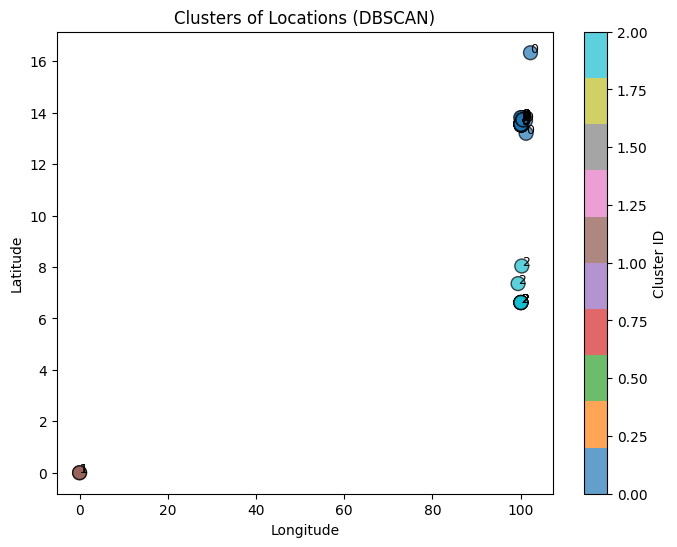

In [21]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df['longitude'], df['latitude'],
    c=df['cluster'], cmap='tab10', s=100, alpha=0.7, edgecolors='k'
)

# Add labels
for i, row in df.iterrows():
    plt.text(row['longitude']+0.01, row['latitude']+0.01, str(row['cluster']), fontsize=9)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters of Locations (DBSCAN)")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

In [22]:
# m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=6)

# colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue']

# for _, row in df.iterrows():
#     cluster_id = row['cluster']
#     color = colors[cluster_id % len(colors)] if cluster_id != -1 else "gray"
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=6,
#         color=color,
#         fill=True,
#         fill_opacity=0.7,
#         popup=f"ID: {row['id']} | Cluster: {cluster_id}"
#     ).add_to(m)

# m.save("clusters.html")

In [23]:
# # convert degrees to radians for DBSCAN
# coords_rad = np.radians(df[['latitude', 'longitude']].to_numpy())

# # helper function
# def km_to_radians(km):
#     return km / 6371.0

# # try different cluster distances
# for km in [50]:
#     eps = km_to_radians(km)
#     db = DBSCAN(eps=eps, min_samples=2, metric='haversine')
#     df[f'cluster_{km}km'] = db.fit_predict(coords_rad)

# print(df)

In [24]:
# plt.figure(figsize=(8,6))
# plt.scatter(df['longitude'], df['latitude'], 
#             c=df['cluster_30km'], cmap='tab10', s=100, edgecolors='k')
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("DBSCAN Clusters (30 km radius)")
# plt.show()

In [26]:
coords = df[['latitude','longitude']].to_numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)
df['kmeans_cluster'] = kmeans.labels_

In [27]:
new_lat, new_lon = 8.040000, 100.275000
new_point = np.array([[new_lat, new_lon]])
pred_cluster = kmeans.predict(new_point)[0]

print(f"New point belongs to cluster: {pred_cluster}")

New point belongs to cluster: 2


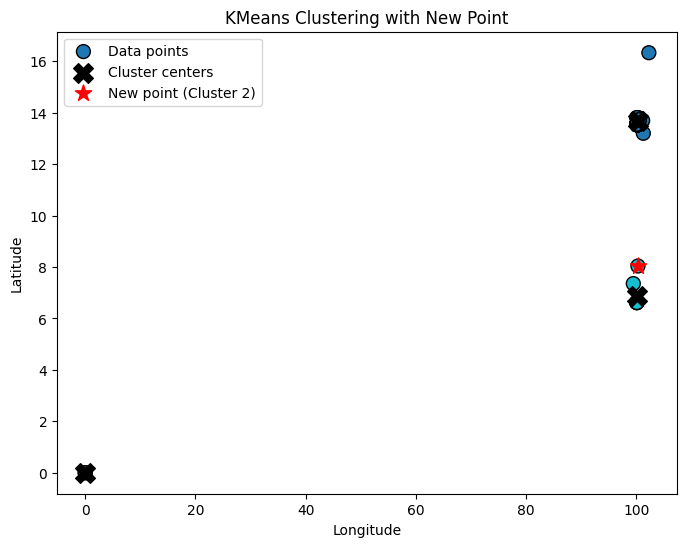

In [28]:
plt.figure(figsize=(8,6))

# Plot clustered points
plt.scatter(df['longitude'], df['latitude'], 
            c=df['kmeans_cluster'], cmap='tab10', s=100, edgecolors='k', label="Data points")

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:,1], centers[:,0], c='black', s=200, marker='X', label="Cluster centers")

# Plot new point
plt.scatter(new_lon, new_lat, c='red', s=150, marker='*', label=f"New point (Cluster {pred_cluster})")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clustering with New Point")
plt.legend()
plt.show()